Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


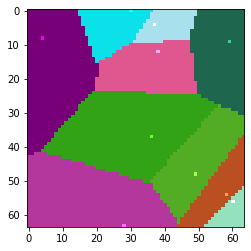

In [93]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def drawPoints(canvas, points, colors):
    for point, color in zip(points, colors):
        img = np.zeros(canvas.shape)
        P = int(point[0]), int(point[1])
        cv2.circle(img, P, 0, color, -1)
        canvas+=img

# Draw voronoi diagram
def drawVoronoi(img, subdiv):
    import random
    ( facets, centers) = subdiv.getVoronoiFacetList([])

    for i in range(0, len(facets)):       
        ifacet = np.array(facets[i], np.int)
        color = (random.random(), random.random(), random.random())
        cv2.fillConvexPoly(img, ifacet, color);


# create points
S = 64
points = np.random.uniform(0,S,(10,2))
colors = np.random.uniform(0,1, (10,3))

# create canvas
canvas = np.zeros( (S, S, 3) )

# create subdiv
subdiv = cv2.Subdiv2D((0, 0, canvas.shape[1], canvas.shape[0]))
for p in points:
    subdiv.insert( (p[0], p[1]) )
(facets, centers) = subdiv.getVoronoiFacetList([])

# draw subdiv
for facet, color in zip(facets, colors):
    # color = (random.random(), random.random(), random.random())
    ifacet = np.array(facet, np.int)
    cv2.fillConvexPoly(canvas, ifacet, color);

# drawVoronoi( canvas, subdiv)
drawPoints(canvas, points, colors)
plt.imshow(canvas)

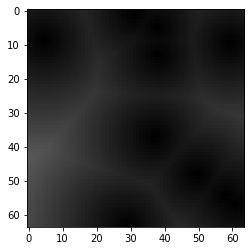

In [94]:
height, width, channels = canvas.shape
distances = np.zeros(canvas.shape)
for y in range(height):
    for x in range(width):
        vertex_id, nearest = subdiv.findNearest((x,y))
        vector = np.array([nearest[0]-x, nearest[1]-y])
        d = np.sqrt( np.dot(vector, vector) )/100
        distances[y,x] = (d,d,d)

plt.imshow(distances)


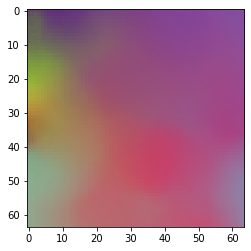

In [87]:
import numpy as np
import cv2

def NNI(locations, colors, canvas):
    """
    discreet Sibson interpolation
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.91.9802&rep=rep1&type=pdf
    http://rotand.dk/
    """
    height, width, channels = canvas.shape
    nni_img = np.zeros( canvas.shape, dtype=np.float32) # cumulate circles
    nni_sum = np.zeros( canvas.shape[:2], dtype=np.float32) # number of contributions
            
    def find_nearest_location(p, locations):
        nearestIndex = -1
        minDist2 = np.inf
        for i in range(len(locations)):
            point = locations[i]
            vector = np.array([x-point[0], y-point[1]])
            dist2 = np.dot(vector, vector)
            if dist2<minDist2:
                minDist2 = dist2
                nearestIndex = i

        distance = np.sqrt(minDist2)
        color = colors[nearestIndex]

        return nearestIndex, distance

    # draw circles
    for y in range(height):
        for x in range(width):
            # progress+=1; print("{:.3f}%".format(progress/width/height*100), end="\r")
            img = np.zeros( canvas.shape, dtype=np.float32)
            img_sum = np.zeros( canvas.shape[:2], dtype=np.float32)

            i, d = find_nearest_location((x,y), locations)
            color = colors[i]

            # draw color
            cv2.circle(img, (x,y), int(d), color, int(d))
            nni_img+=img

            # draw contribution
            cv2.circle(img_sum, (x,y), int(d), (1,), int(d))
            nni_sum+=img_sum
    return nni_img/cv2.merge([nni_sum, nni_sum, nni_sum])

import matplotlib.pyplot as plt
points = np.random.uniform(0,64,(10,2))
colors = np.random.uniform(0,1, (10,3))
nni_img = NNI(points, colors, np.zeros( (64,64,3) ))
plt.imshow(nni_img)

[[-0.26500641  0.5628846   0.        ]
 [ 0.35610363 -0.10870577  0.        ]
 [-0.31681616  0.27444519  0.        ]
 [ 0.11814171 -0.01689708  0.        ]]


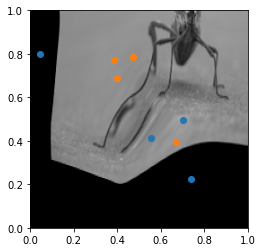

In [107]:
def NNIWarp(src, sourcePoints, targetPoints):
    height, width, channels = src.shape
    colors = np.zeros( (targetPoints.shape[0], 3))
    colors[:,:2] = targetPoints-sourcePoints
    print(colors)
    stmap = NNI(targetPoints, colors, np.zeros((height, width, 3)))


    # create fragCoord st map
    r,g = cv2.split(np.mgrid[0:1:width+1j, 0:1:height+1j].astype(np.float32).T)
    
    mapx = r+stmap[:,:,0]
    mapy = g+stmap[:,:,1]
    return cv2.remap(src, mapx.astype(np.float32)*width, mapy.astype(np.float32)*height, cv2.INTER_LINEAR)

sourcePoints = np.random.uniform(0,1, (4,2) )
targetPoints = np.random.uniform(0,1, (4,2) )
plt.scatter(sourcePoints[:,0], sourcePoints[:,1])
plt.scatter(targetPoints[:,0], targetPoints[:,1])

img = cv2.imread("footage/stinkbug_thumb.png")
warped = NNIWarp(img, sourcePoints, targetPoints)
plt.imshow(warped, extent=(0,1,0,1))